In [1]:
import numpy as np 
import pandas as pd
import os

from fastai.vision.all import *
from fastai.callback.tracker import SaveModelCallback

import glob
from tqdm.auto import tqdm
from plotnine import *

In [2]:
infodf = pd.read_csv('/kaggle/input/02-none/data/info.csv')


In [3]:
infodf = infodf.drop('Unnamed: 0',axis = 1)

In [4]:
infodf

,filename,class
0,151000120,9
1,151000220,9
2,151000320,9
3,151000420,9
4,151000520,9
...,...,...
29395,201293617,6
29396,201293717,6
29397,201293817,6
29398,201293917,6


In [5]:
df = infodf
N = len(df)
import random
test_index =random.sample(range(N), int(N*0.3))
train_index = list(set(range(N))-set(test_index))
rows = df.index[test_index]
df_test = df.take(rows)
rows = df.index[train_index]
df_train = df.take(rows)
df_test.to_csv('test.csv')
df_train.to_csv('train.csv')

In [6]:
ftrain_df = pd.DataFrame({'filename':df_train['filename'],'path': ['/kaggle/input//02-none/data/image/'+str(ii)+'.png' for ii in df_train['filename']]})

In [7]:
train=df_train.merge(ftrain_df)

class=0


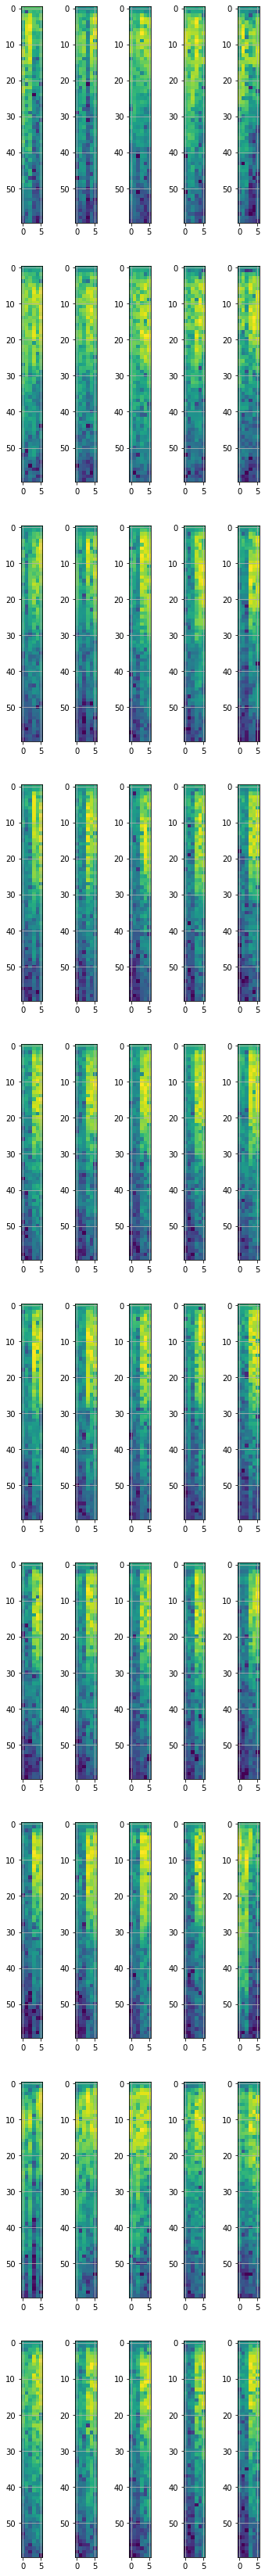

In [8]:
n = 0
print('class=0')
import matplotlib.pyplot as plt
tmp = train.take(pd.Index(np.where(train['class']==n)[0]))
fig, axs = plt.subplots(10, 5, figsize=(6, 60))
# print(axs)
ii = 0 
for axr in axs:
    for ax in axr:
        ax.imshow(plt.imread(tmp['path'].iloc[ii]))
        ax.grid(True)
        ii = ii+1

class=1


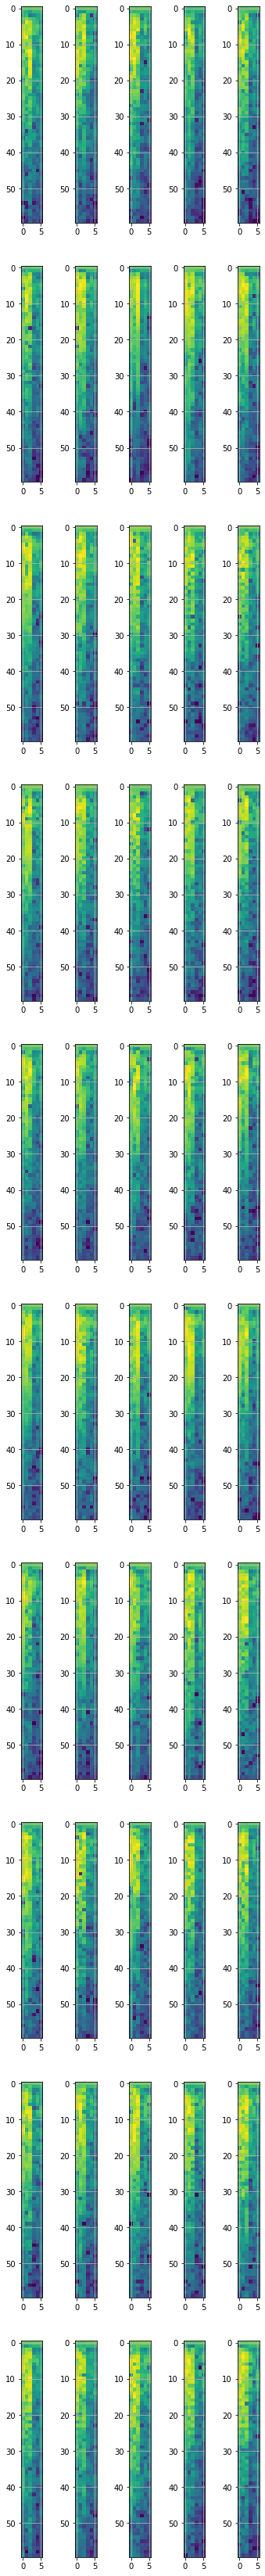

In [9]:
n = 1
print('class=1')
import matplotlib.pyplot as plt
tmp = train.take(pd.Index(np.where(train['class']==n)[0]))
fig, axs = plt.subplots(10, 5, figsize=(6, 60))
# print(axs)
ii = 0 
for axr in axs:
    for ax in axr:
        ax.imshow(plt.imread(tmp['path'].iloc[ii]))
        ax.grid(True)
        ii = ii+1

class=2


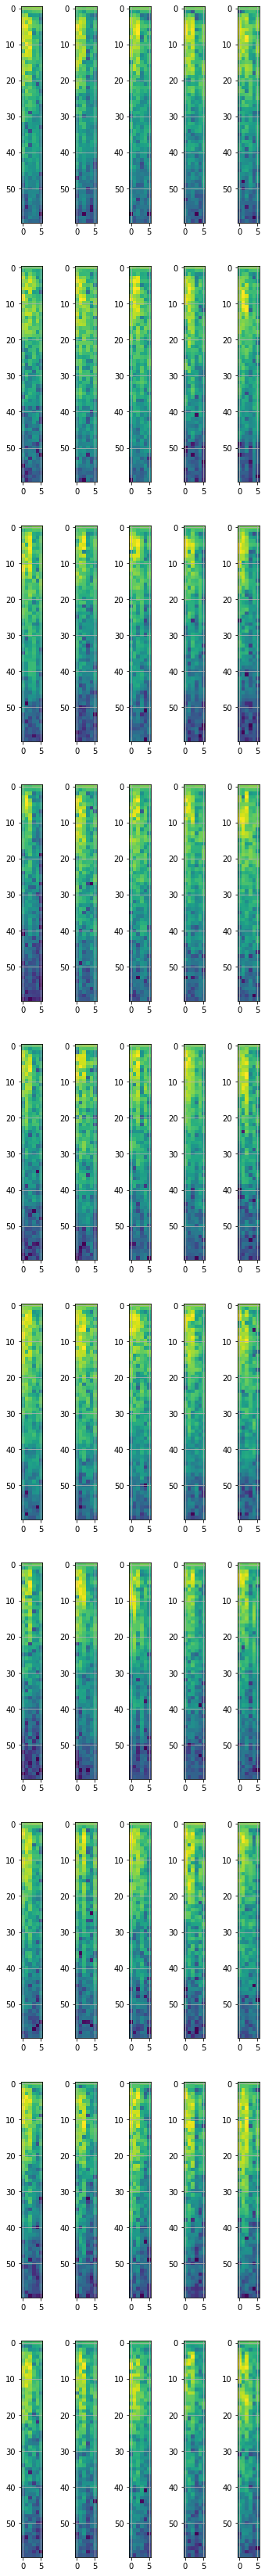

In [10]:
n = 2
print('class=2')
import matplotlib.pyplot as plt
tmp = train.take(pd.Index(np.where(train['class']==n)[0]))
fig, axs = plt.subplots(10, 5, figsize=(6, 60))
# print(axs)
ii = 0 
for axr in axs:
    for ax in axr:
        ax.imshow(plt.imread(tmp['path'].iloc[ii]))
        ax.grid(True)
        ii = ii+1

class=3


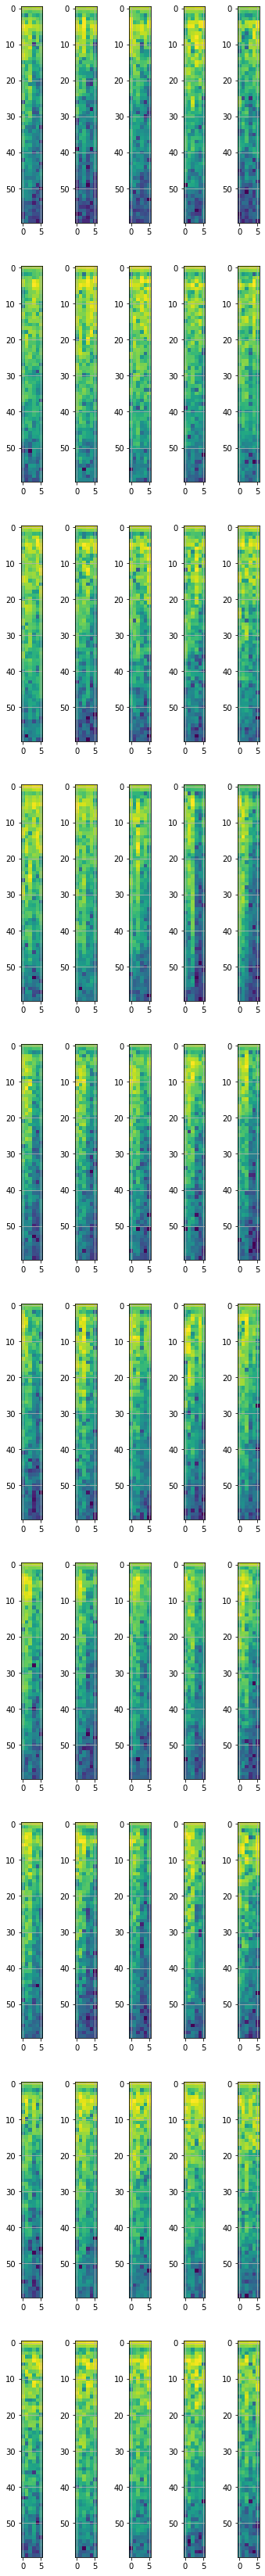

In [11]:
n = 3
print('class=3')
import matplotlib.pyplot as plt
tmp = train.take(pd.Index(np.where(train['class']==n)[0]))
fig, axs = plt.subplots(10, 5, figsize=(6, 60))
# print(axs)
ii = 0 
for axr in axs:
    for ax in axr:
        ax.imshow(plt.imread(tmp['path'].iloc[ii]))
        ax.grid(True)
        ii = ii+1

class=4


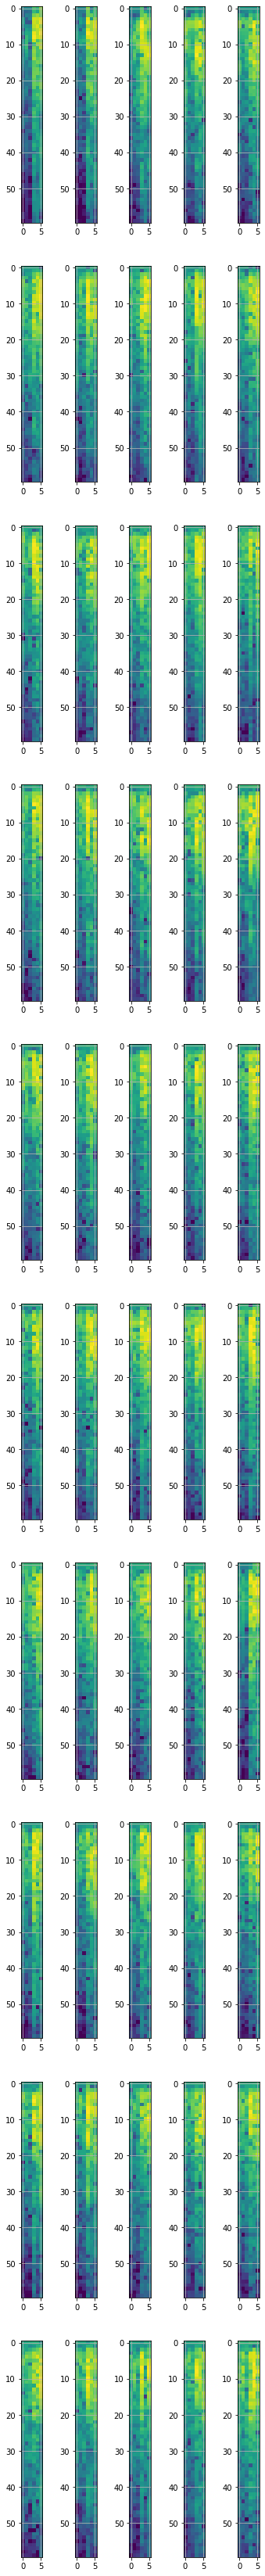

In [12]:
n = 4
print('class=4')
import matplotlib.pyplot as plt
tmp = train.take(pd.Index(np.where(train['class']==n)[0]))
fig, axs = plt.subplots(10, 5, figsize=(6, 60))
# print(axs)
ii = 0 
for axr in axs:
    for ax in axr:
        ax.imshow(plt.imread(tmp['path'].iloc[ii]))
        ax.grid(True)
        ii = ii+1

class=5


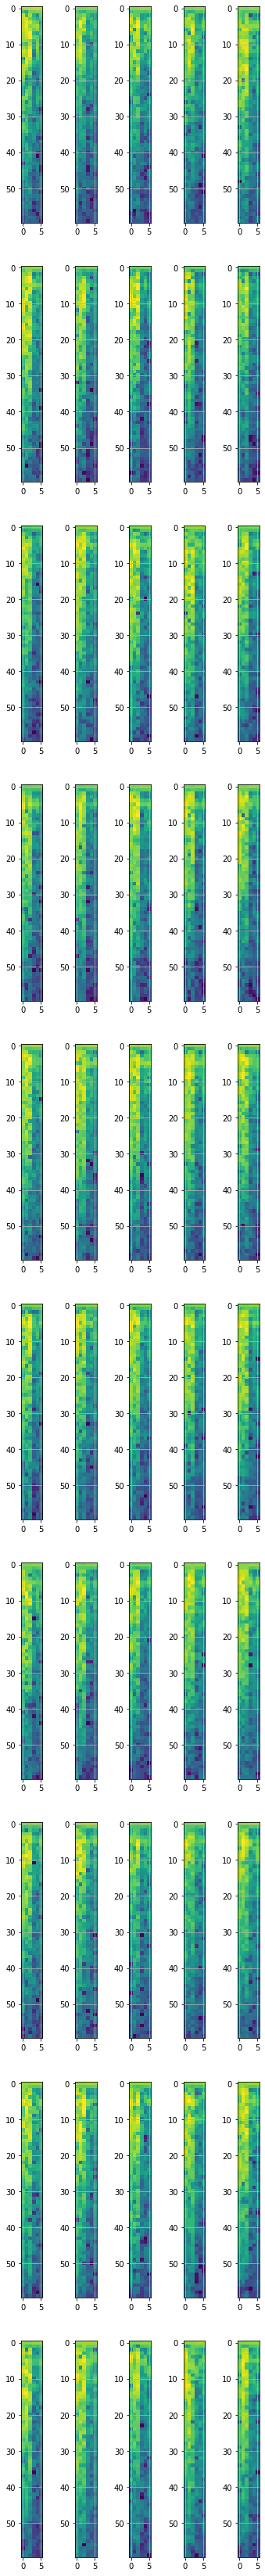

In [13]:
n = 5
print('class=5')
import matplotlib.pyplot as plt
tmp = train.take(pd.Index(np.where(train['class']==n)[0]))
fig, axs = plt.subplots(10, 5, figsize=(6, 60))
# print(axs)
ii = 0 
for axr in axs:
    for ax in axr:
        ax.imshow(plt.imread(tmp['path'].iloc[ii]))
        ax.grid(True)
        ii = ii+1

In [14]:
train

,filename,class,path
0,151000120,9,/kaggle/input//02-none/data/image/151000120.png
1,151000220,9,/kaggle/input//02-none/data/image/151000220.png
2,151000620,9,/kaggle/input//02-none/data/image/151000620.png
3,151000720,9,/kaggle/input//02-none/data/image/151000720.png
4,151000820,9,/kaggle/input//02-none/data/image/151000820.png
...,...,...,...
20575,201293517,6,/kaggle/input//02-none/data/image/201293517.png
20576,201293617,6,/kaggle/input//02-none/data/image/201293617.png
20577,201293817,6,/kaggle/input//02-none/data/image/201293817.png
20578,201293917,6,/kaggle/input//02-none/data/image/201293917.png


In [15]:
splitter=RandomSplitter(valid_pct=0.2, seed=42)
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image; y - single class
    get_x=ColReader(2), #x is stored in column 2
    get_y=ColReader(1), #y is stored in column 1
    splitter=splitter, #use parent folder as train-valid split
    )
dls = dblock.dataloaders(train, path='.', bs=64)

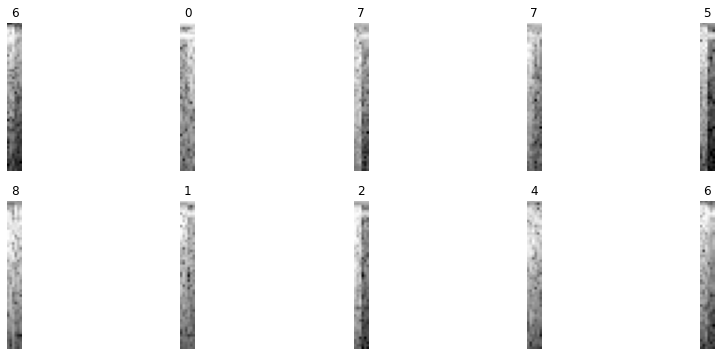

In [16]:
dls.train.show_batch(max_n=10, nrows=2)

In [17]:
learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy,]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=1.5848931980144698e-06)

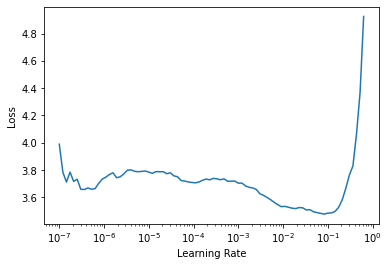

In [18]:
learn.lr_find()

In [19]:
#finetune 
learn.fine_tune(epochs=10,
          base_lr=1e-2, #max lr; when unfrozen base_lr/2
          freeze_epochs=1, #how many epochs to train frozen
          lr_mult=100, #train feature extractor with max lr at base_lr/lr_mult
          pct_start=0.2, #start decreasing lr at 
          div=5.0, #start at base_lr (max lr) / div
          cbs=[SaveModelCallback(monitor='accuracy'),]
#               WandbCallback(), #track to wandb] #monitor accuracy and save best model
          )

epoch,train_loss,valid_loss,accuracy,time
0,2.457725,2.360730,0.224247,00:44


Better model found at epoch 0 with accuracy value: 0.22424684464931488.


epoch,train_loss,valid_loss,accuracy,time
0,1.764079,1.566509,0.387026,00:35
1,1.485342,1.293751,0.534257,00:35
2,1.322054,1.061893,0.616375,00:35
3,1.003149,0.901063,0.689018,00:35
4,0.808901,1.335841,0.704082,00:36
5,0.650065,0.821329,0.734208,00:35
6,0.449329,0.714252,0.761176,00:35
7,0.311862,0.728161,0.770651,00:35
8,0.210577,0.774337,0.771866,00:35
9,0.159107,0.772042,0.772838,00:35


Better model found at epoch 0 with accuracy value: 0.38702625036239624.
Better model found at epoch 1 with accuracy value: 0.5342565774917603.
Better model found at epoch 2 with accuracy value: 0.6163751482963562.
Better model found at epoch 3 with accuracy value: 0.6890184879302979.
Better model found at epoch 4 with accuracy value: 0.704081654548645.
Better model found at epoch 5 with accuracy value: 0.7342079877853394.
Better model found at epoch 6 with accuracy value: 0.7611758708953857.
Better model found at epoch 7 with accuracy value: 0.77065110206604.
Better model found at epoch 8 with accuracy value: 0.7718659043312073.
Better model found at epoch 9 with accuracy value: 0.7728376984596252.


In [20]:
learn.export()

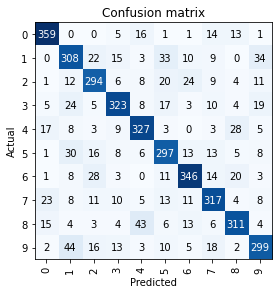

In [21]:
#see validation performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

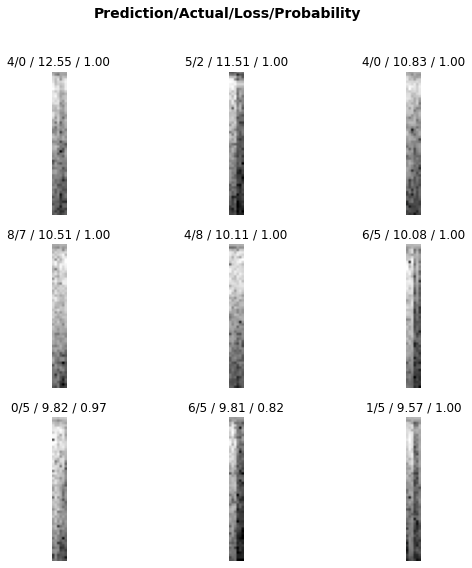

In [22]:
interp.plot_top_losses(9, nrows=3)

In [23]:
ftest_df = pd.DataFrame({'filename':df_test['filename'],'path': ['/kaggle/input//02-none/data/image/'+str(ii)+'.png' for ii in df_test['filename']]})

In [24]:
test=df_test.merge(ftest_df)

In [25]:
test

,filename,class,path
0,161083412,1,/kaggle/input//02-none/data/image/161083412.png
1,121243314,3,/kaggle/input//02-none/data/image/121243314.png
2,171137116,5,/kaggle/input//02-none/data/image/171137116.png
3,121250817,6,/kaggle/input//02-none/data/image/121250817.png
4,121261014,3,/kaggle/input//02-none/data/image/121261014.png
...,...,...,...
8815,121260020,9,/kaggle/input//02-none/data/image/121260020.png
8816,151015215,4,/kaggle/input//02-none/data/image/151015215.png
8817,131178216,5,/kaggle/input//02-none/data/image/131178216.png
8818,181220418,7,/kaggle/input//02-none/data/image/181220418.png


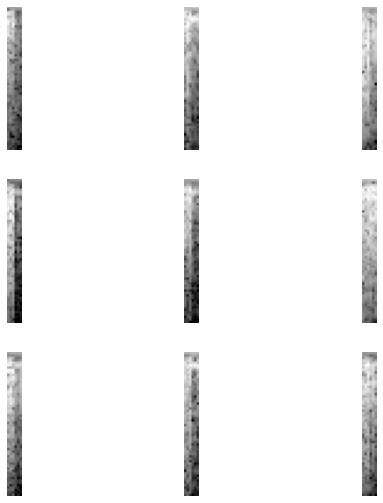

In [26]:
# test_fnames = get_image_files("/kaggle/input/emg-png/data/test/")
test_fnames = test['path']
len(test_fnames)
#create test dataloader
tst_dl = dls.test_dl(test_fnames,shuffle=False)
tst_dl.show_batch(max_n=9)

In [27]:
preds = learn.get_preds(dl=tst_dl) # get prediction logits
pred_idxs = preds[0].argmax(1) # get index with highest logit
pred_labs = [learn.dls.train_ds.vocab[i] for i in pred_idxs] #convert index to labels
pred_labs[:10]

[2, 3, 5, 6, 3, 3, 1, 7, 2, 0]

In [28]:
#put in dataframe
pred = pd.DataFrame({'fname':test_fnames,'Predicted':pred_labs})
pred['filename'] = pred.fname.map(lambda x: str(x)[-13:-4])
pred = pred[['filename','Predicted']].sort_values('filename').reset_index(drop=True)
pred.tail()

,filename,Predicted
8815,201293919,4
8816,201294011,0
8817,201294012,1
8818,201294019,8
8819,201294020,9


In [29]:
pred.to_csv('/kaggle/working/predict.csv',index=False)
pred.head()

,filename,Predicted
0,111029514,3
1,111029515,4
2,111029615,0
3,111029618,7
4,111029620,9


In [30]:
test['filename'] = test['filename'].astype(str)
test=test.merge(pred)
test.head()

,filename,class,path,Predicted
0,161083412,1,/kaggle/input//02-none/data/image/161083412.png,2
1,121243314,3,/kaggle/input//02-none/data/image/121243314.png,3
2,171137116,5,/kaggle/input//02-none/data/image/171137116.png,5
3,121250817,6,/kaggle/input//02-none/data/image/121250817.png,6
4,121261014,3,/kaggle/input//02-none/data/image/121261014.png,3


In [31]:
test['diff']=test['class']==test['Predicted']
test.head()

,filename,class,path,Predicted,diff
0,161083412,1,/kaggle/input//02-none/data/image/161083412.png,2,False
1,121243314,3,/kaggle/input//02-none/data/image/121243314.png,3,True
2,171137116,5,/kaggle/input//02-none/data/image/171137116.png,5,True
3,121250817,6,/kaggle/input//02-none/data/image/121250817.png,6,True
4,121261014,3,/kaggle/input//02-none/data/image/121261014.png,3,True


In [32]:
test['diff'].value_counts()

True     6749
False    2071
Name: diff, dtype: int64

In [33]:
a = test['diff'].value_counts()[True]*100/(test['diff'].value_counts()[True]+test['diff'].value_counts()[False])
print('Accuracy:'+"{:.2f}".format(a)+'%')

Accuracy:76.52%


In [34]:
for ii in range(10):
    a, b = test['diff'].iloc[np.where(test['class']==ii)].value_counts()
    print('Accuracy Class ',ii,':'+"{:.2f}".format(100*a/(a+b))+'%')

Accuracy Class  0 :86.26%
Accuracy Class  1 :72.05%
Accuracy Class  2 :72.16%
Accuracy Class  3 :75.65%
Accuracy Class  4 :84.08%
Accuracy Class  5 :74.70%
Accuracy Class  6 :76.54%
Accuracy Class  7 :76.71%
Accuracy Class  8 :76.45%
Accuracy Class  9 :70.36%
